In [23]:
library("IBMPopSim")
library("ggplot2")
library("Rcpp")
library(dplyr)
library(gridExtra)

In [24]:
# Generate initial population
N <- 10000  # Number of individuals in the initial population

In [25]:
# xb - xd is distributed uniformly on -10 ,10
xd <- runif(N,0,10)
pop_init <- data.frame(
  "birth" = rep(0,N), 
  "death" = as.double(NA),
  "Lansing" = rep(c(FALSE,FALSE),N/2),
    "ib"=1,
    "i_d"=1,
    "xb"= 10-xd, 
    "xd" =  xd, 
    "lignee"=1:N
)
get_characteristics(pop_init)


Lansing       ib      i_d       xb       xd   lignee 
  "bool" "double" "double" "double" "double"    "int"

In [26]:
head(pop_init)
#plot.ecdf(pop_init$xb-pop_init$xd)

,birth,death,Lansing,ib,i_d,xb,xd,lignee
,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,0,NA,FALSE,1,1,2.981573,7.018427,1
2,0,NA,FALSE,1,1,7.213051,2.786949,2
3,0,NA,FALSE,1,1,4.532423,5.467577,3
4,0,NA,FALSE,1,1,5.181285,4.818715,4
5,0,NA,FALSE,1,1,3.135738,6.864262,5
6,0,NA,FALSE,1,1,5.138883,4.861117,6


In [27]:
# Events and model creation
 # There are 2 possible events :

# - Birth (with or without mutation)
# - Death

# Each event is characterized by its intensity and  kernel code, described below.

## Birth event with individual intensity

### Parameters



In [28]:
params_birth <- list("p"=0.1 , "var_mut"=0.05)

In [29]:
birth_event <- mk_event_individual( type = "birth",
  intensity_code = ' if (age(I,t) < I.xb)
                        result = I.ib; 
                    else 
                        result =0;',  # each individual  I can give birth at rate ib if its age is less than xb
  kernel_code = 'if (CUnif() < p){
                     newI.xb = max(0., CNorm(I.xb, var_mut));
                     newI.ib = max(0., CNorm(I.ib, var_mut));
                     newI.i_d = max(0., CNorm(I.i_d, var_mut));}
                 else{
                     newI.xb = I.xb;
                     newI.ib = I.ib;
                     newI.i_d = I.i_d;}
                if (I.Lansing & (age(I,t)> I.xd) & (age(I,t)<I.xb))
                     newI.xd =0;
                 else{
                    if (CUnif()<p)
                        newI.xd =max(0., CNorm(I.xd, var_mut));
                     else 
                        newI.xd =I.xd;}
                 newI.Lansing =I.Lansing;
                 newI.lignee =I.lignee;') 
# An individual I can give birth to an individual newI. The kernel code defines characteristics of individual newI
# Attention la manière dont est calculée le trait après mutation est un peu différente du code du Tristan

In [30]:
## Death event 
### parameters
params_death <- list("compet"= 0.0009)

In [31]:
## Deaths due to interactions
death_event1 <- mk_event_interaction(name='death1',
  type = "death",
  interaction_code = "result = compet;" 
)

In [32]:
## Deaths due to aging 
death_event2 <- mk_event_individual(name='death2', type="death",
                  intensity_code = ' if (age(I,t)>I.xd) result= I.i_d; 
                                     else result =0;')

In [33]:
# Model creation 
model <- mk_model(
  characteristics = get_characteristics(pop_init),
  events = list(birth_event, death_event1, death_event2),
  parameters = c(params_birth, params_death)

)
summary(model)

Events:
#1: individual event of type birth
#2: interaction event of type death
#3: individual event of type death
--------------------------------------- 
Individual description:
names:  birth death Lansing ib i_d xb xd lignee 
R types:  double double logical double double double double integer 
C types:  double double bool double double double double int
--------------------------------------- 
R parameters available in C++ code:
names:  p var_mut compet 
R types:  double double double 
C types:  double double double

In [34]:
## Bounds for birth and death rates 

birth_intensity_max <- 10
interaction_fun_max <- params_death$compet
death2_max <- 10

In [35]:
T = 1500 # Simulation end time 


sim_out <- popsim(model = model,
  population = pop_init,
  events_bounds = c('birth'=birth_intensity_max, 'death1'=interaction_fun_max,'death2'= death2_max),
  parameters = c(params_birth, params_death),
  time = T)

Simulation on  [0, 1500] 

In [36]:
# Simulation with different parameters

#The model can be simulated with different parameters without being recompiled.


In [37]:
#sim_out$logs["duration_main_algorithm"]
#sim_out$logs

In [38]:
# Outputs

In [39]:
str(sim_out$population)

'data.frame':	140535071 obs. of  8 variables:
 $ birth  : num  1499 1499 1499 1499 1499 ...
 $ death  : num  NA NA NA NA NA NA NA NA NA NA ...
 $ Lansing: logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ ib     : num  11.5 10.6 10.8 11.3 11.3 ...
 $ i_d    : num  2.35 3.1 2.81 2.49 2.49 ...
 $ xb     : num  5.49 2.56 2.45 5.44 5.44 ...
 $ xd     : num  7.99 1.16 1.41 8.03 8.02 ...
 $ lignee : int  163 163 163 163 163 163 163 163 163 163 ...


In [40]:
pop_out <- sim_out$population
head(pop_out)
tail(pop_out)

,birth,death,Lansing,ib,i_d,xb,xd,lignee
,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,1499.198,NA,FALSE,11.45369,2.352729,5.489701,7.985817,163
2,1499.209,NA,FALSE,10.63938,3.101325,2.561075,1.163580,163
3,1499.261,NA,FALSE,10.77094,2.806596,2.452447,1.414446,163
4,1499.263,NA,FALSE,11.34496,2.492284,5.436336,8.029483,163
5,1499.284,NA,FALSE,11.34496,2.492284,5.436336,8.021576,163
6,1499.300,NA,FALSE,11.31208,3.866463,4.354980,2.581391,163


,birth,death,Lansing,ib,i_d,xb,xd,lignee
,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
140535066,1499.996,1499.998,FALSE,10.93802,1.972850,3.360195,1.675386,163
140535067,1499.996,1499.998,FALSE,11.52694,3.740955,4.536391,2.610738,163
140535068,1499.997,1500.000,FALSE,11.48960,2.281228,5.180260,8.010482,163
140535069,1499.998,1499.999,FALSE,10.53646,3.344155,3.294445,1.781392,163
140535070,1499.998,1499.998,FALSE,12.17592,4.087751,3.938594,2.188048,163
140535071,1499.999,1500.000,FALSE,11.55371,2.798478,4.755027,5.763010,163


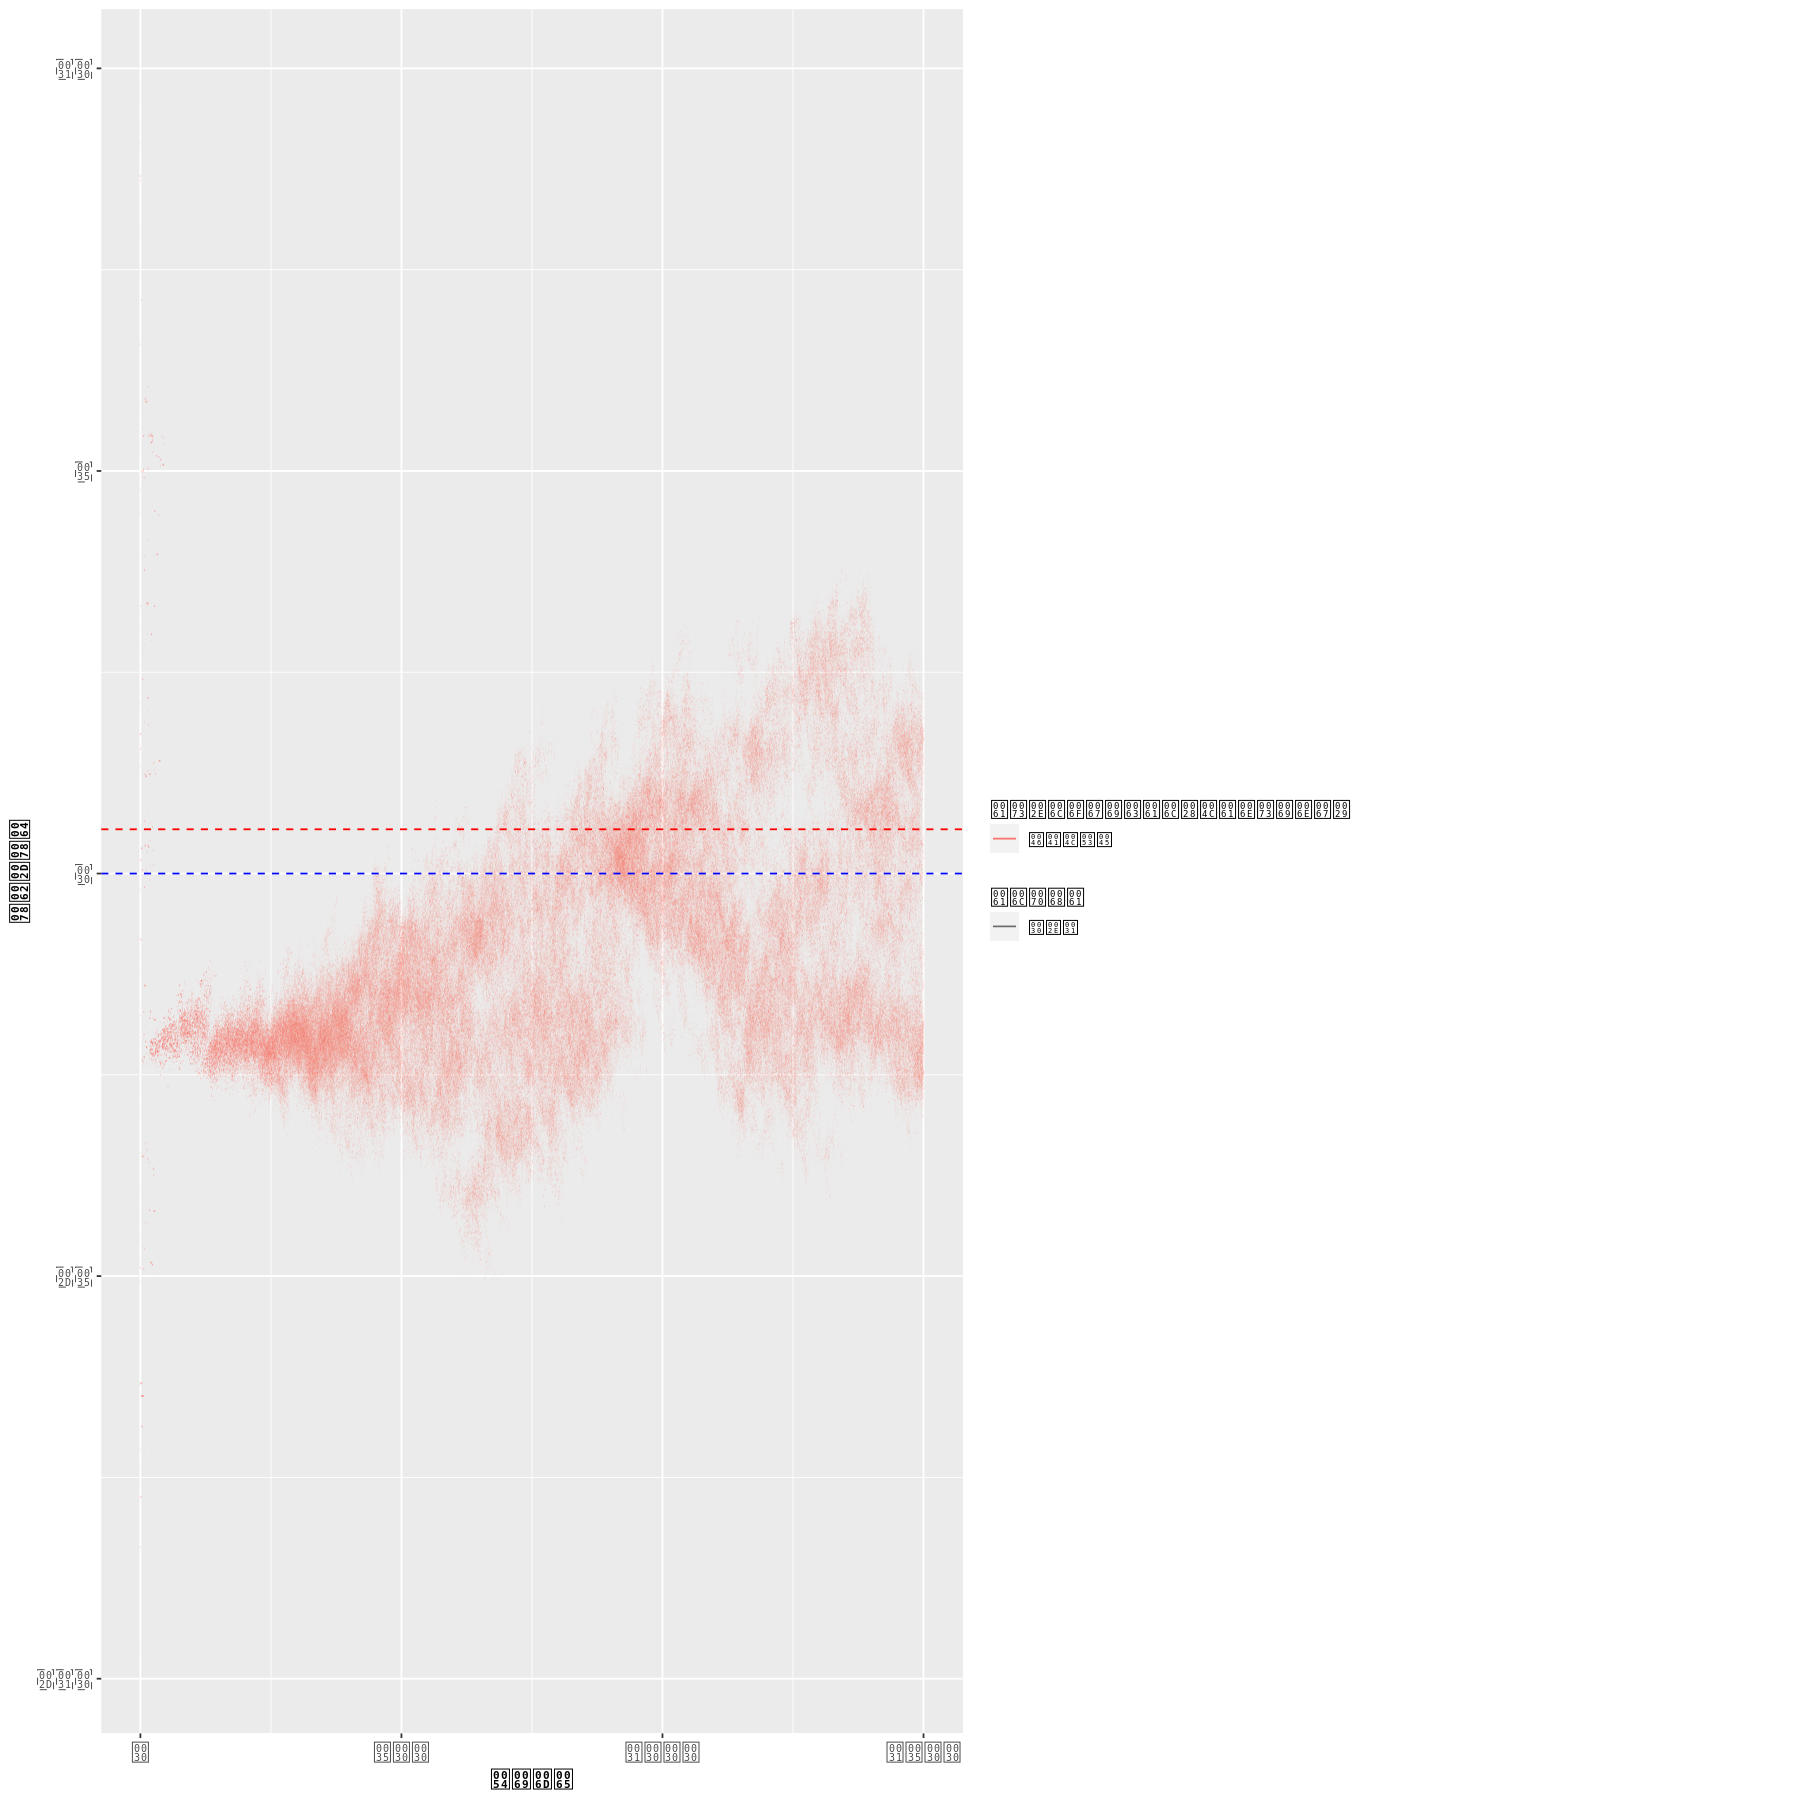

In [41]:
options(repr.plot.width=15, repr.plot.height=15)
xbxd_evol_for_publi <- ggplot(pop_out %>% sample_n(1000000), aes(color=as.logical(Lansing), alpha = 0.1)) + 
  geom_segment(aes(x=birth, xend=death, y=xb-xd, yend=xb-xd, alpha =0.1) , na.rm=TRUE)+
  xlab("Time") +
  ylab("xb-xd") + 
  geom_hline(yintercept=log(3)/2, color = "red", linetype="dashed") +
  geom_hline(yintercept = 0, color = "blue", linetype="dashed") +
  #theme(legend.position="none")+
  theme(axis.text=element_text(size=12),
        axis.title=element_text(size=14,face="bold"))

xbxd_evol_for_publi

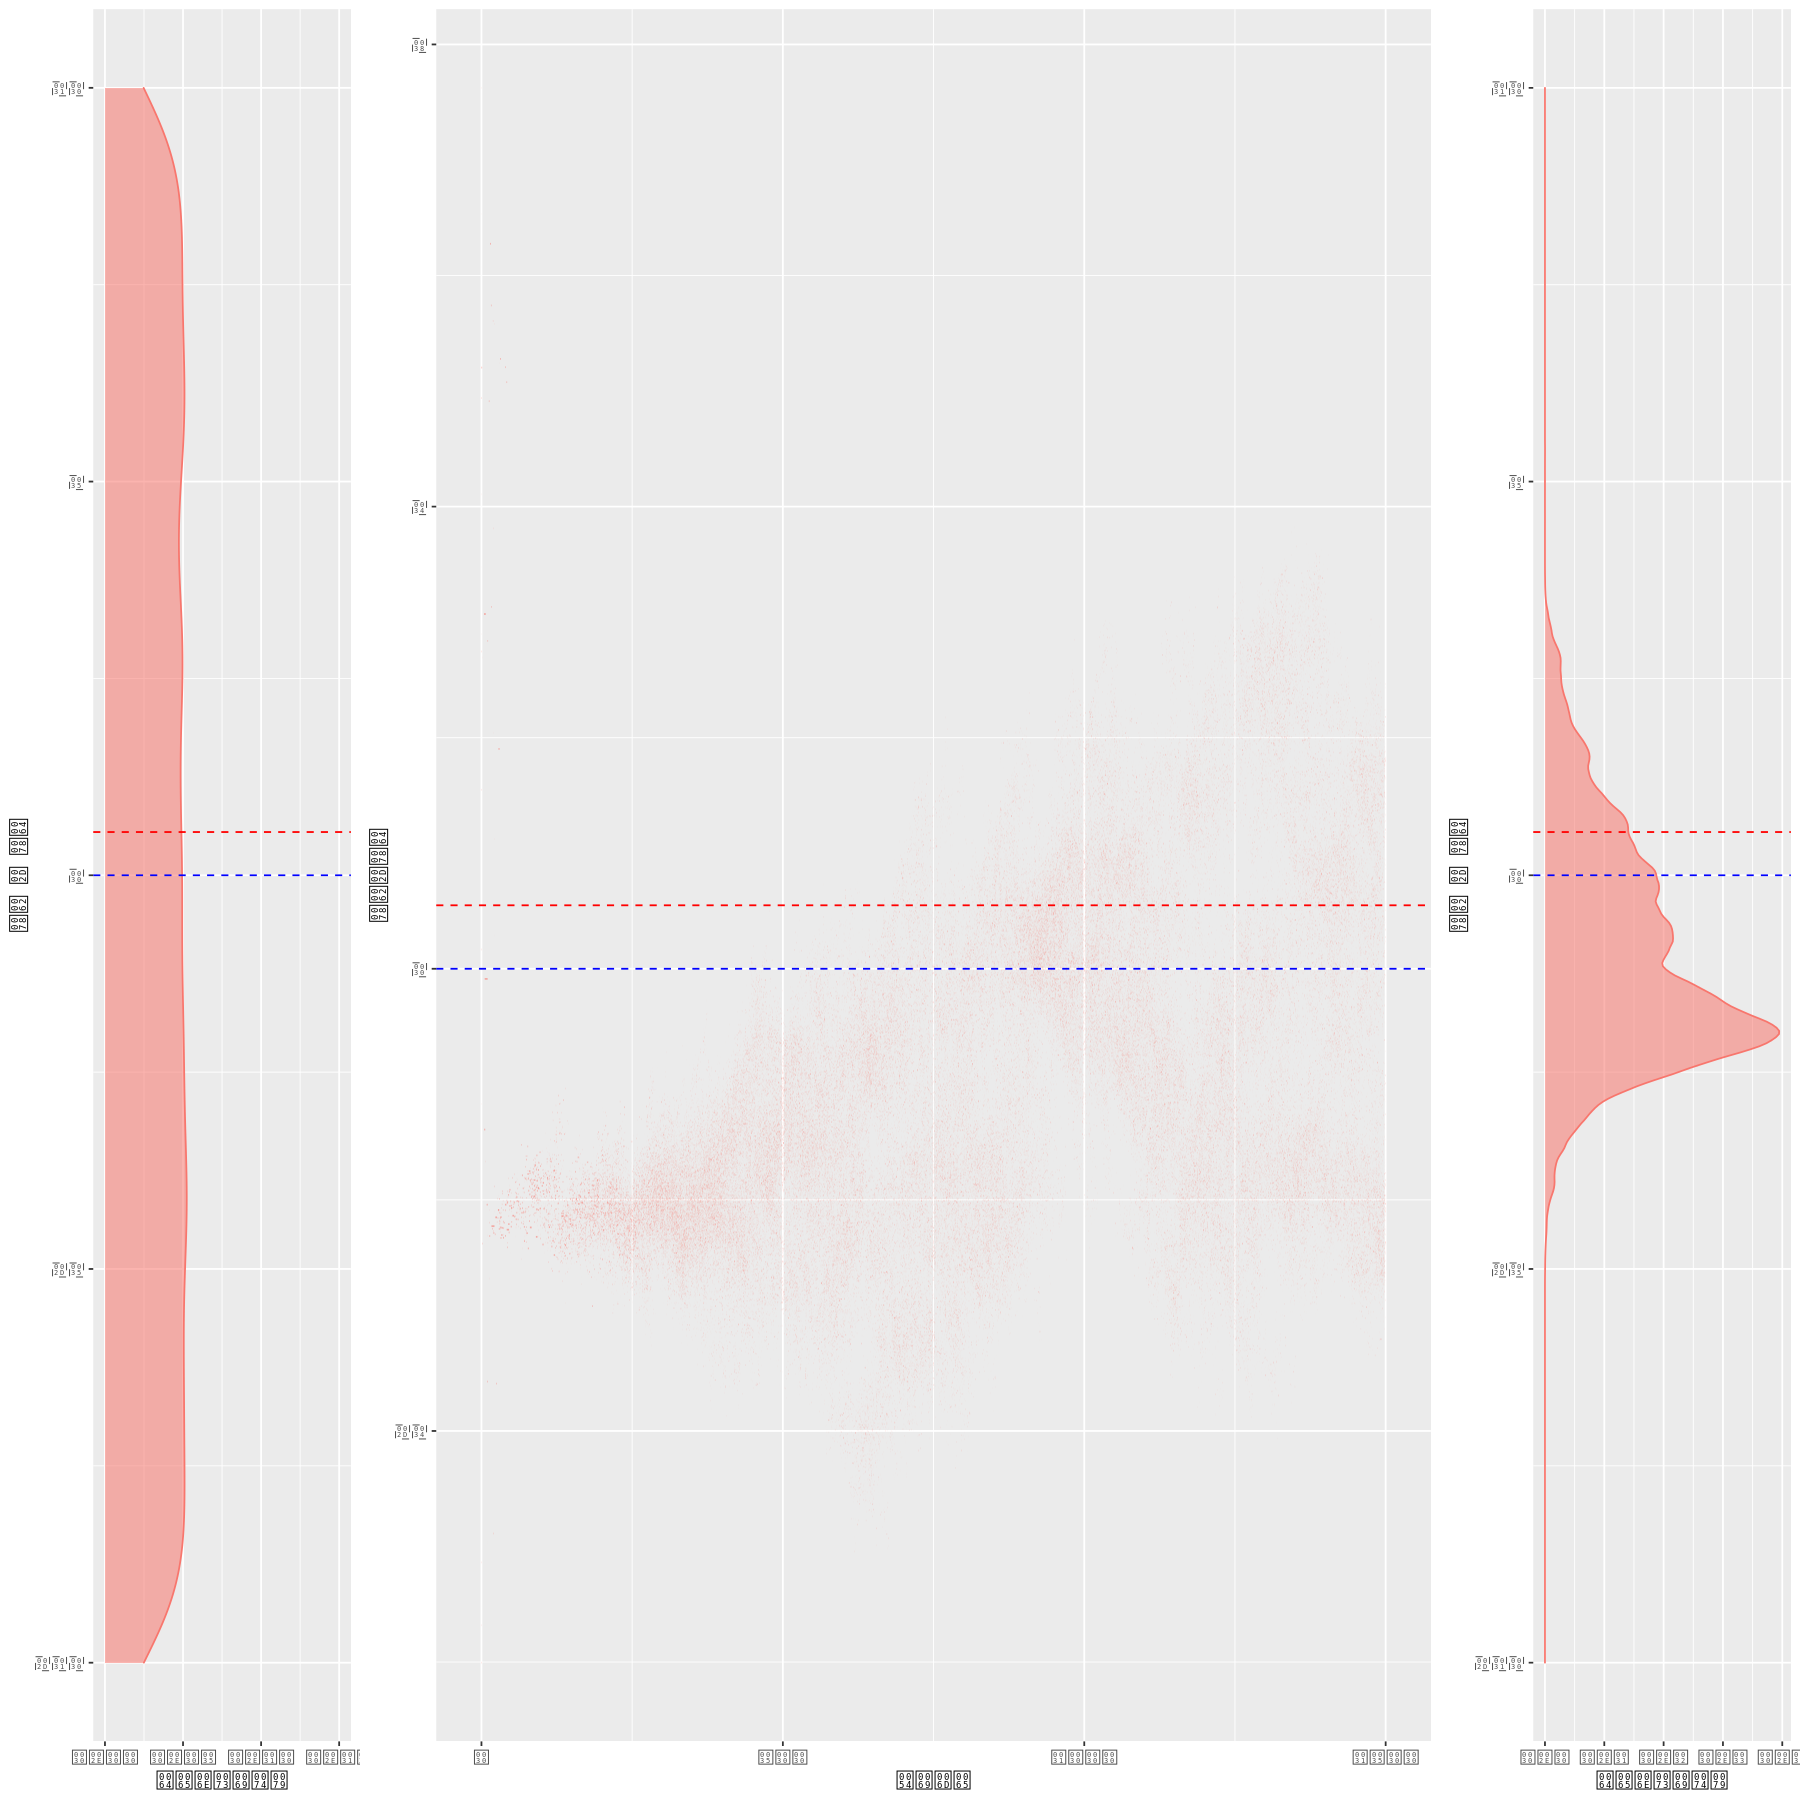

In [42]:
t0density <-  ggplot(pop_out %>% filter(birth==0), aes(x=xb-xd, color=Lansing, fill=Lansing, height=..scaled.., alpha = 0.1)) + 
                geom_density() + 
                geom_vline(xintercept = 0, color = "blue", linetype="dashed")  +
                geom_vline(xintercept = log(3)/2, color = "red", linetype="dashed") +
                ylim(0,0.15) + 
                coord_flip() +
                theme(legend.position="none")

soldensity <- ggplot(pop_out, aes(x=xb-xd, color=Lansing, fill=Lansing, height=..scaled.., alpha = 0.1)) + 
                geom_density() + 
                geom_vline(xintercept = 0, color = "blue", linetype="dashed")  +
                geom_vline(xintercept = log(3)/2, color = "red", linetype="dashed") +
                coord_flip() +
                xlim(-10,10) +
                theme(legend.position="none")

xbxd_evol <- ggplot(pop_out  %>% sample_n(200000), aes(color=as.logical(Lansing))) + 
                geom_segment(aes(x=birth, xend=death, y=xb-xd, yend=xb-xd, alpha =0.1) , na.rm=TRUE)+
                xlab("Time") +
                ylab("xb-xd") + 
                geom_hline(yintercept=log(3)/2, color = "red", linetype="dashed") +
                geom_hline(yintercept = 0, color = "blue", linetype="dashed") +
                theme(legend.position="none")

p = grid.arrange(t0density, xbxd_evol, soldensity, ncol=3, nrow = 1, widths=c(2,6,2))

In [21]:
#calculation of Malthusian parameters (Newton's method)
deriv_2 <- function(f, x, y, dx){
  return((f(x+dx, y)-f(x, y))/dx)
}
deriv_3 <- function(f, x, y, z, dx){
  return((f(x+dx, y, z)-f(x, y, z))/dx)
}
F <- function(a, b){
  u = 0
  if(a == 0){u = b - 1}
  else{u = ((1/a)*(1-exp(-a*b)))-1}
  return(u)
}
H <- function(a, b, d){
  u = 0
  if(a == 0){ u = d - exp(d-b)}
  else{u = ((1-exp(-a*d))/a) + (exp(d)/(1+a))*(exp(-d*(1+a))-exp(-b*(1+a)))-1}
  return(u)
}
G <- function(a, d){
  u = 0
  if(a == 0){u = d - 1}
  else{u = ((1/a)*(1-exp(-a*d)))-1}
  return(u)
}
malthus_nl <- function(b, d, x_0, epsilon, delta){
  if(b<=d){
    u = x_0
    while(abs(F(u, b))>epsilon){
      u = u - (F(u, b)/deriv_2(F, u, b, delta))
    }
    return(u)
  } else {
    v = x_0
    while((abs(H(v,b,d))>epsilon)){
      v = v - (H(v, b, d)/deriv_3(H, v, b, d, delta))
    }
    return(v)
  }
}
malthus_l <- function(b, d, x_0, epsilon, delta){
  if(b<=d){
    u = x_0
    while(abs(F(u, b))>epsilon){
      u = u - (F(u, b) / deriv_2(F, u, b, delta))
    }
    return(u)
  } else {
    v = x_0
    while(abs(G(v, d))>epsilon){
      v = v - (G(v, d) / deriv_2(G, v, d, delta))
    }
    return(v)
  }
}
x_0 = 0.5; epsilon = 0.00001; delta = 0.000001; u = 0

In [22]:
t=seq(0, round(max(pop_out$birth)))
pop_out_mod <- pop_out %>% mutate(Malthus = ifelse(Lansing==TRUE,malthus_l(xb, xd, x_0, epsilon, delta),malthus_nl(xb, xd, x_0, epsilon, delta)))
fun = function(t){
    pop_t <- population_alive(pop_out_mod, t) 
    pop_t_L <- pop_t %>% filter(Lansing)
    pop_t_nL <- pop_t %>% filter(!Lansing)
    rbind(t, pop_t_L %>% count(), pop_t_L[,7] %>% median(na.rm=TRUE), pop_t_nL%>% count(), pop_t_nL[,7]  %>% median(na.rm=TRUE))
} 
surv_table <- as.data.frame(t(matrix(unlist(cbind(lapply(t, fun))),5)))
colnames(surv_table) <- c("time", "Lansing", "mean_Malthus_L","nonLansing", "mean_Malthus_nL")
max_pop <- surv_table %>% filter(time > 5) %>% select(Lansing, nonLansing) %>% max()
max_pop
head(surv_table)

Warning message in if (b <= d) {:
“the condition has length > 1 and only the first element will be used”
Warning message in while (abs(G(v, d)) > epsilon) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (a == 0) {:
“the condition has length > 1 and only the first element will be used”
Warning message in while (abs(G(v, d)) > epsilon) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (a == 0) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (a == 0) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (a == 0) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (a == 0) {:
“the condition has length > 1 and only the first element will be used”
Warning message in while (abs(G(v, d)) > epsilon) {:
“the condition has length > 1 and only the first element will be used

In [ ]:
 ggplot(surv_table) + 
  geom_line(aes(x=time, y=Lansing), color = "#00BDD0" )+
  geom_line(aes(x=time, y=nonLansing), color = "#F8766D" ) +
  ylim(0, max_pop)+
  theme(axis.text=element_text(size=12),
        axis.title=element_text(size=14,face="bold"))

In [ ]:
 ggplot(surv_table) + 
  geom_line(aes(x=time, y=mean_Malthus_L), color = "#00BDD0" )+
  geom_line(aes(x=time, y=mean_Malthus_nL), color = "#F8766D" ) +
  #ylim(0, 1)+
  theme(axis.text=element_text(size=12),
        axis.title=element_text(size=14,face="bold"))